In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from joblib import Parallel, delayed


In [2]:
network_in_df = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_network_in_5abac7.csv")
network_in_df.head()

,timestamp,value
0,2014-03-01 17:36:00,42.0
1,2014-03-01 17:41:00,94.8
2,2014-03-01 17:46:00,42.0
3,2014-03-01 17:51:00,68.4
4,2014-03-01 17:56:00,68.4


In [3]:
# make sure timestamp col is datetime type
network_in_df["timestamp"]=pd.to_datetime(network_in_df["timestamp"])

In [4]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(network_in_df["value"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
network_in_df['val_diff'] = network_in_df['value'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(network_in_df["val_diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -8.3609
p-value (Original): 0.0000
Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -20.1097
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


In [12]:
# max values for p, d, and q
max_p, max_d, max_q = 5, 2, 5

def get_order_sets(n, n_per_set) -> list:
    n_sets = [i for i in range(n)]
    order_sets = [
        n_sets[i:i + n_per_set]
        for i in range(0, n, n_per_set)
    ]
    return order_sets

def find_aic_for_model(data, p, d, q, model, model_name):
    try:
        msg = f"Fitting {model_name} with order (p, d, q) = ({p}, {d}, {q})"
        print(msg)
        
        # Avoid refitting if p=0, d=0, and q=1
        if (p, d, q) == (0, 0, 1):
            return None, (p, d, q)
        
        # Fit ARIMA model
        ts_results = model(data, order=(p, d, q)).fit()
        curr_aic = ts_results.aic
        return curr_aic, (p, d, q)
    
    except Exception as e:
        print(f"Exception occurred for (p, d, q) = ({p}, {d}, {q}): {e}")
        return None, (p, d, q)

def find_best_order_for_model(data, model, model_name):
    p_ar, d_diff, q_ma = max_p, max_d, max_q
    final_results = []

    # Initial fit with ARIMA(0, 1, 0)
    ts_results = model(data, order=(0, 1, 0)).fit()
    min_aic = ts_results.aic
    final_results.append((min_aic, (0, 1, 0)))
    
    # Create order sets for q values
    order_sets = get_order_sets(q_ma + 1, 5)  # Include q=5 as well

    for p in range(0, p_ar + 1):
        for d in range(0, d_diff + 1):
            for order_set in order_sets:
                # Fit the model and find AIC in parallel for different q values
                results = Parallel(n_jobs=len(order_set), prefer='threads')(
                    delayed(find_aic_for_model)(data, p, d, q, model, model_name)
                    for q in order_set
                )
                final_results.extend(results)
    
    # Create a DataFrame with results
    results_df = pd.DataFrame(
        [res for res in final_results if res[0] is not None],
        columns=['aic', 'order']
    )

    # Find the order with the minimum AIC
    min_df = results_df[results_df['aic'] == results_df['aic'].min()]
    min_aic = min_df['aic'].iloc[0]
    min_order = min_df['order'].iloc[0]
    
    return min_aic, min_order, results_df


In [13]:
# print(find_best_order_for_model(cpu_util_df["value"], ARIMA, "ARIMA"))
min_aic, min_order, results_df = find_best_order_for_model(network_in_df["value"], ARIMA, "ARIMA")
# print(find_best_order_for_model(cpu_util_df, ARIMA, "ARIMA"))
print("******MIN_AIC: ", min_aic, "MIN_ORDER: ", min_order)# Output: 1341.1035677173795, (4, 4)

Fitting ARIMA with order (p, d, q) = (0, 0, 0)Fitting ARIMA with order (p, d, q) = (0, 0, 1)
Fitting ARIMA with order (p, d, q) = (0, 0, 2)
Fitting ARIMA with order (p, d, q) = (0, 0, 3)
Fitting ARIMA with order (p, d, q) = (0, 0, 4)

Fitting ARIMA with order (p, d, q) = (0, 0, 5)
Fitting ARIMA with order (p, d, q) = (0, 1, 0)
Fitting ARIMA with order (p, d, q) = (0, 1, 1)
Fitting ARIMA with order (p, d, q) = (0, 1, 2)
Fitting ARIMA with order (p, d, q) = (0, 1, 3)
Fitting ARIMA with order (p, d, q) = (0, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (0, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (0, 2, 0)Fitting ARIMA with order (p, d, q) = (0, 2, 1)

Fitting ARIMA with order (p, d, q) = (0, 2, 2)
Fitting ARIMA with order (p, d, q) = (0, 2, 3)
Fitting ARIMA with order (p, d, q) = (0, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (0, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 0, 0)
Fitting ARIMA with order (p, d, q) = (1, 0, 1)
Fitting ARIMA with order (p, d, q) = (1, 0, 2)
Fitting ARIMA with order (p, d, q) = (1, 0, 3)
Fitting ARIMA with order (p, d, q) = (1, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 1, 0)Fitting ARIMA with order (p, d, q) = (1, 1, 1)

Fitting ARIMA with order (p, d, q) = (1, 1, 2)
Fitting ARIMA with order (p, d, q) = (1, 1, 3)
Fitting ARIMA with order (p, d, q) = (1, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 1, 5)
Fitting ARIMA with order (p, d, q) = (1, 2, 0)
Fitting ARIMA with order (p, d, q) = (1, 2, 1)
Fitting ARIMA with order (p, d, q) = (1, 2, 2)
Fitting ARIMA with order (p, d, q) = (1, 2, 3)
Fitting ARIMA with order (p, d, q) = (1, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (1, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 0, 0)Fitting ARIMA with order (p, d, q) = (2, 0, 1)

Fitting ARIMA with order (p, d, q) = (2, 0, 2)
Fitting ARIMA with order (p, d, q) = (2, 0, 3)
Fitting ARIMA with order (p, d, q) = (2, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 1, 0)
Fitting ARIMA with order (p, d, q) = (2, 1, 1)
Fitting ARIMA with order (p, d, q) = (2, 1, 2)
Fitting ARIMA with order (p, d, q) = (2, 1, 3)
Fitting ARIMA with order (p, d, q) = (2, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (2, 1, 5)
Fitting ARIMA with order (p, d, q) = (2, 2, 0)
Fitting ARIMA with order (p, d, q) = (2, 2, 1)
Fitting ARIMA with order (p, d, q) = (2, 2, 2)
Fitting ARIMA with order (p, d, q) = (2, 2, 3)
Fitting ARIMA with order (p, d, q) = (2, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (2, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 0, 0)Fitting ARIMA with order (p, d, q) = (3, 0, 1)
Fitting ARIMA with order (p, d, q) = (3, 0, 2)
Fitting ARIMA with order (p, d, q) = (3, 0, 3)

Fitting ARIMA with order (p, d, q) = (3, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

Fitting ARIMA with order (p, d, q) = (3, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 1, 0)Fitting ARIMA with order (p, d, q) = (3, 1, 1)
Fitting ARIMA with order (p, d, q) = (3, 1, 2)

Fitting ARIMA with order (p, d, q) = (3, 1, 3)
Fitting ARIMA with order (p, d, q) = (3, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (3, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (3, 2, 0)
Fitting ARIMA with order (p, d, q) = (3, 2, 1)
Fitting ARIMA with order (p, d, q) = (3, 2, 2)
Fitting ARIMA with order (p, d, q) = (3, 2, 3)
Fitting ARIMA with order (p, d, q) = (3, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

Fitting ARIMA with order (p, d, q) = (3, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (4, 0, 0)
Fitting ARIMA with order (p, d, q) = (4, 0, 1)
Fitting ARIMA with order (p, d, q) = (4, 0, 2)
Fitting ARIMA with order (p, d, q) = (4, 0, 3)
Fitting ARIMA with order (p, d, q) = (4, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

Fitting ARIMA with order (p, d, q) = (4, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 1, 0)
Fitting ARIMA with order (p, d, q) = (4, 1, 1)
Fitting ARIMA with order (p, d, q) = (4, 1, 2)
Fitting ARIMA with order (p, d, q) = (4, 1, 3)
Fitting ARIMA with order (p, d, q) = (4, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (4, 2, 0)Fitting ARIMA with order (p, d, q) = (4, 2, 1)
Fitting ARIMA with order (p, d, q) = (4, 2, 2)
Fitting ARIMA with order (p, d, q) = (4, 2, 3)
Fitting ARIMA with order (p, d, q) = (4, 2, 4)



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

Fitting ARIMA with order (p, d, q) = (4, 2, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (5, 0, 0)Fitting ARIMA with order (p, d, q) = (5, 0, 1)

Fitting ARIMA with order (p, d, q) = (5, 0, 2)
Fitting ARIMA with order (p, d, q) = (5, 0, 3)
Fitting ARIMA with order (p, d, q) = (5, 0, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary startin

Fitting ARIMA with order (p, d, q) = (5, 0, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (5, 1, 0)Fitting ARIMA with order (p, d, q) = (5, 1, 1)
Fitting ARIMA with order (p, d, q) = (5, 1, 2)
Fitting ARIMA with order (p, d, q) = (5, 1, 3)

Fitting ARIMA with order (p, d, q) = (5, 1, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitting ARIMA with order (p, d, q) = (5, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (5, 2, 0)Fitting ARIMA with order (p, d, q) = (5, 2, 1)
Fitting ARIMA with order (p, d, q) = (5, 2, 2)

Fitting ARIMA with order (p, d, q) = (5, 2, 3)
Fitting ARIMA with order (p, d, q) = (5, 2, 4)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting ARIMA with order (p, d, q) = (5, 2, 5)
******MIN_AIC:  141540.15130044697 MIN_ORDER:  (5, 1, 5)


/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
''' build arima model
ARIMA's parameters: p, d, and q
p = for autoregression pt of model; how far back in time should we go to predict the current observation
d = order of differencing
q = for moving avg part of the model; represents num of lagged forecast errors included in the model 
'''

model_arima=ARIMA(network_in_df['value'],order=(5, 1, 5)) # using (5, 1, 5) as order based on running helper functions above that find this order for us
model_arima=model_arima.fit()



/Users/christinetsai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
# Returns the in-sample predictions for the training period
forecast_values = model_arima.fittedvalues.reset_index(drop=True)
forecast_values.head()

0     0.000000
1    20.531701
2    42.425575
3    48.045821
4    54.420089
dtype: float64

In [16]:
# Get the in-sample predictions (fitted values) to calculate confidence bounds
fitted_values = model_arima.fittedvalues.reset_index(drop=True)

# Calculate residuals (actual - predicted) to compute std
residuals = network_in_df["value"] - fitted_values
std_resid = np.std(residuals)

# Define bounds using residual standard deviation
# z_score = 2.576  # 99% confidence
z_score = 3.5
upper_bound = fitted_values + (z_score * std_resid)
lower_bound = fitted_values - (z_score * std_resid)



In [17]:

network_in_df["lower_bound"] = lower_bound
network_in_df["upper_bound"] = upper_bound
network_in_df["is_anomaly"] = (
    (network_in_df["value"] > upper_bound)
).astype(int)
network_in_df.head(100)

,timestamp,value,val_diff,lower_bound,upper_bound,is_anomaly
0,2014-03-01 17:36:00,42.0,NaN,-2.664490e+06,2.664490e+06,0
1,2014-03-01 17:41:00,94.8,52.8,-2.664470e+06,2.664511e+06,0
2,2014-03-01 17:46:00,42.0,-52.8,-2.664448e+06,2.664533e+06,0
3,2014-03-01 17:51:00,68.4,26.4,-2.664442e+06,2.664539e+06,0
4,2014-03-01 17:56:00,68.4,0.0,-2.664436e+06,2.664545e+06,0
...,...,...,...,...,...,...
95,2014-03-02 01:31:00,68.4,26.4,-2.664423e+06,2.664558e+06,0
96,2014-03-02 01:36:00,68.4,0.0,-2.664418e+06,2.664563e+06,0
97,2014-03-02 01:41:00,86.4,18.0,-2.664425e+06,2.664555e+06,0
98,2014-03-02 01:46:00,68.4,-18.0,-2.664421e+06,2.664560e+06,0


In [19]:
# sum up number of anomalies
network_in_df["is_anomaly"].sum()

81

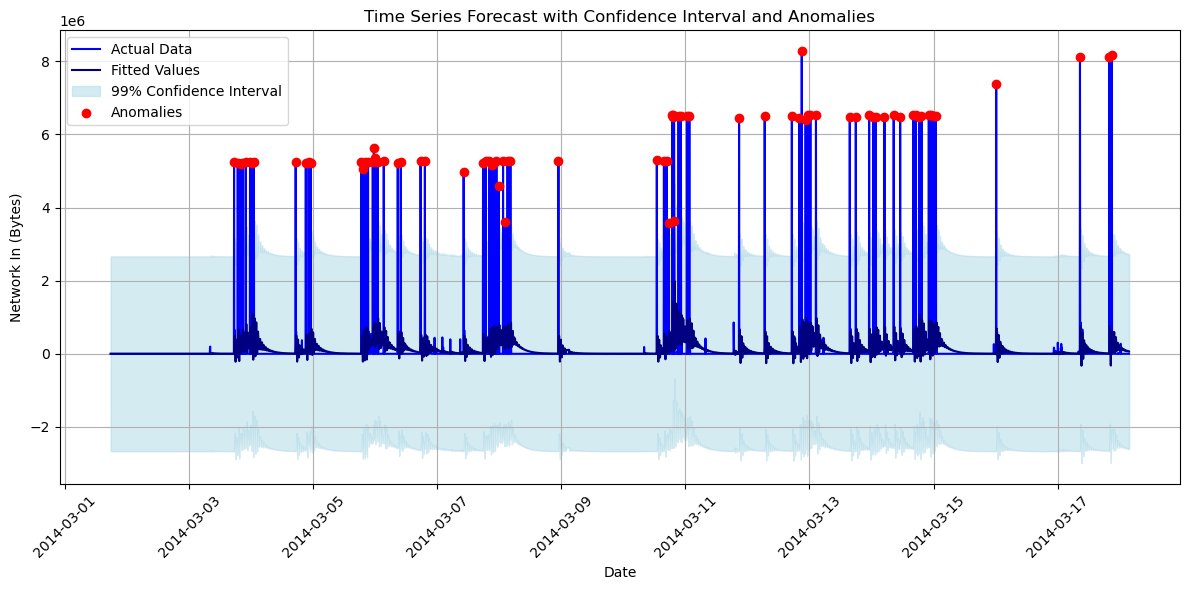

In [20]:
# Plot the forecasted values with the confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(network_in_df['timestamp'], network_in_df['value'], label="Actual Data", color='blue')
plt.plot(network_in_df['timestamp'], fitted_values, label="Fitted Values", color='navy')
plt.fill_between(network_in_df['timestamp'], lower_bound, upper_bound, color='lightblue', alpha=0.5, label="99% Confidence Interval")
anomalies = network_in_df[network_in_df["is_anomaly"] == 1]
plt.scatter(
    anomalies['timestamp'],
    anomalies['value'],
    color='red',
    label="Anomalies",
    zorder=5,
)
plt.xlabel("Date")
plt.ylabel("Network In (Bytes)")
plt.title("Time Series Forecast with Confidence Interval and Anomalies")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()